In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
%matplotlib inline 
pd.set_option("precision", 3)

In [3]:
#CARGAR ACTIVOS Y FECHAS

start = date(2015, 5, 30) #poner fecha inicial
end = date(2020, 12, 31) #poner fecha final


ticker1 = "VCSH"
ticker2 = "HYG"
ticker3 = "LQD"
ticker4 = "AGG"
ticker5 = "VCIT"
ticker6 = "ANGL"
ticker7 = "ACWI"
ticker8 = "MOAT"
ticker9 = "EFA"
ticker10 = "SPY"
ticker11 = "SPHQ"
ticker12 = "EEM"
ticker13 = "XLF"
ticker14 = "EMQQ"
ticker15 = "VB"
ticker16 = "CEF"


tickers = [ticker1, ticker2, ticker3, ticker4, ticker5, ticker6, ticker7, ticker8, ticker9, 
           ticker10, ticker11, ticker12, ticker13, ticker14, ticker15, ticker16]

weight1 = 0.266
weight2 = 0.0573
weight3 = 0.0562
weight4 = 0.0431
weight5 = 0.0413
weight6 = 0.0411
weight7 = 0.1041
weight8 = 0.0978
weight9 = 0.07
weight10 = 0.0609
weight11 = 0.0453
weight12 = 0.0379
weight13 = 0.0156
weight14 = 0.0123
weight15 = 0.0103
weight16 = 0.0408

current_weights = [weight1, weight2, weight3, weight4, weight5, weight6, weight7, weight8, weight9, weight10,
          weight11, weight12, weight13, weight14, weight15, weight16]


print(sum(current_weights*100))
curr_weights = np.array(current_weights)
curr_weights.T

100.0000000000003


array([0.266 , 0.0573, 0.0562, 0.0431, 0.0413, 0.0411, 0.1041, 0.0978,
       0.07  , 0.0609, 0.0453, 0.0379, 0.0156, 0.0123, 0.0103, 0.0408])

In [4]:
len(tickers)

16

In [5]:
datos = DataReader(tickers, "yahoo", start, end)
datos = datos["Adj Close"]
datos = datos.resample('BM').last() 
datos.head(5)

Symbols,VCSH,HYG,LQD,AGG,VCIT,ANGL,ACWI,MOAT,EFA,SPY,SPHQ,EEM,XLF,EMQQ,VB,CEF
Date,,,,,,,,,,,,,,,,
2015-06-30,70.139,67.380,97.263,95.092,71.931,20.338,53.292,28.470,55.030,185.620,20.995,35.484,13.694,24.641,111.731,11.632
2015-07-31,70.402,67.048,98.073,95.912,72.076,20.300,53.731,29.074,56.148,189.813,21.560,33.245,14.160,22.253,111.409,10.395
2015-08-31,70.173,66.027,97.261,95.590,71.405,19.786,50.074,27.051,51.979,178.244,20.448,30.307,13.160,19.412,104.915,10.864
2015-09-30,70.596,64.053,98.418,96.365,72.638,19.398,48.353,25.919,49.682,173.696,20.209,29.358,12.790,18.762,100.155,10.565
2015-10-30,70.687,66.122,98.983,96.431,72.840,19.812,52.055,27.960,52.967,188.471,21.464,31.230,13.591,22.280,105.843,11.123


Text(0, 0.5, 'price in $')

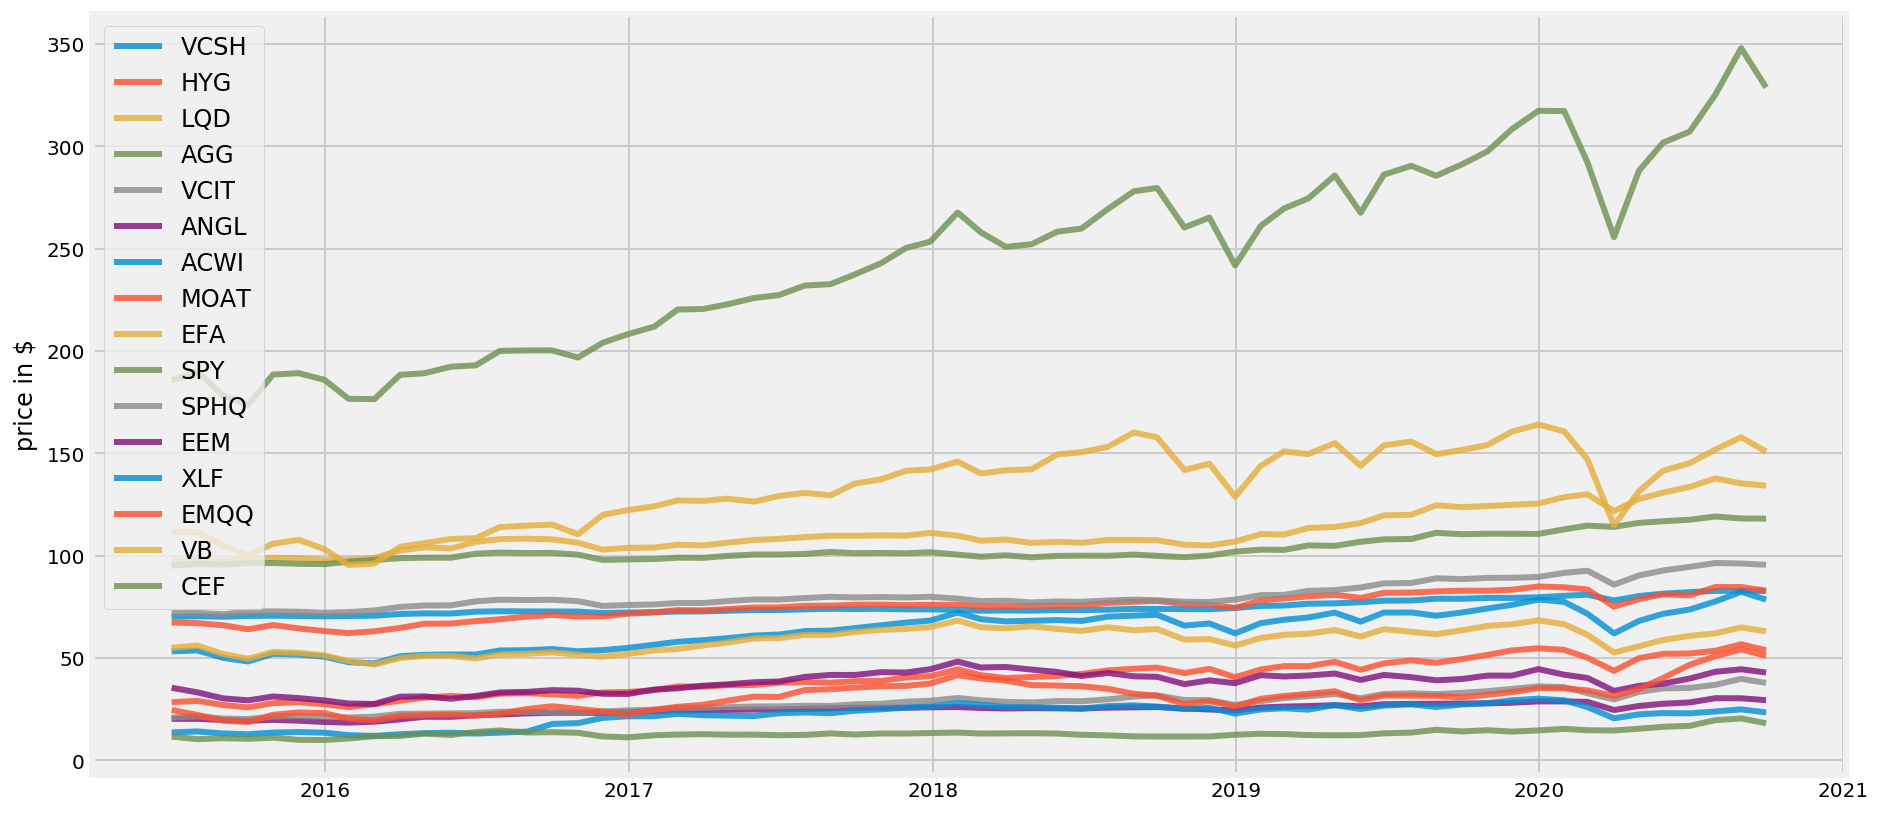

In [6]:
plt.figure(figsize=(14, 7))
for c in datos.columns.values:
    plt.plot(datos.index, datos[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

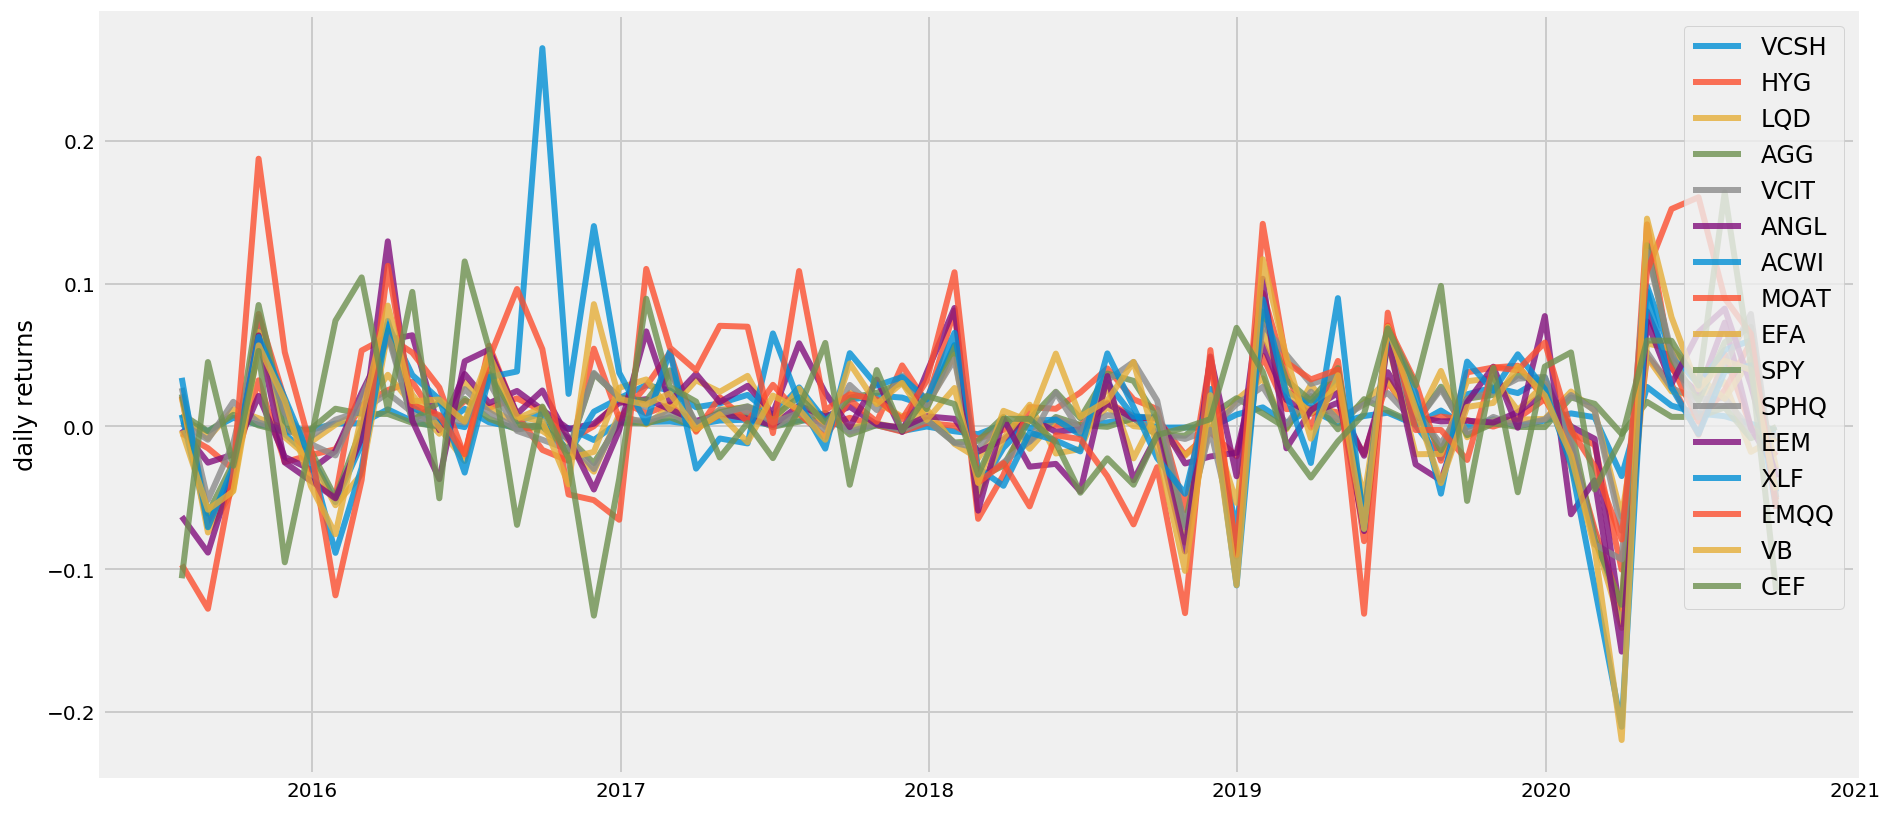

In [7]:
returns = datos.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [8]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) *12
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)
    return std, returns

In [9]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [10]:
mean_returns = returns.mean()*100
cov_matrix = returns.cov()*100
risk_free_rate = DataReader('^IRX', data_source='yahoo')['Adj Close'][-1]
mean_returns

Symbols
VCSH    0.265
HYG     0.354
LQD     0.528
AGG     0.349
VCIT    0.465
ANGL    0.634
ACWI    0.705
MOAT    1.131
EFA     0.299
SPY     1.005
SPHQ    1.020
EEM     0.438
XLF     1.069
EMQQ    1.427
VB      0.635
CEF     0.867
dtype: float64

# Efficient Frontier


In [11]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [12]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [13]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [20]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix*100, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix*100)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=datos.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix*100)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix*100)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=datos.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    sdp_curr, rp_curr = portfolio_annualised_performance(curr_weights, mean_returns, cov_matrix*100)
    current_allocation = pd.DataFrame(curr_weights*100,index=datos.columns,columns=['allocation'])
    current_allocation.allocation = [round(i,2)for i in current_allocation.allocation]
    current_allocation = current_allocation.T
    current_allocation
    
    an_vol = np.std(returns) * np.sqrt(12)*100
    an_rt = mean_returns * 12
    
    print ("-"*80)
    print ("\n")
    print ("Current Portfolio\n")
    print ("Annualised Return:", round(rp_curr,2))
    print ("Annualised Volatility:", round(sdp_curr,2))
    print ("Sharpe Ratio:", round((rp_curr-risk_free_rate)/sdp_curr,2))
    print ("\n")
    print (current_allocation)
    print ("\n")
    print ("-"*80)
    print ("\n")
    print ("Maximum Sharpe Ratio Portfolio\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("Sharpe Ratio:", round((rp-risk_free_rate)/sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("\n")
    print ("-"*80)
    print ("\n")
    print ("Minimum Volatility Portfolio\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("Sharpe Ratio:", round((rp_min-risk_free_rate)/sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("\n")
    print ("-"*80)
    print ("\n")
    print ("Individual Securities Annualized Returns, Volatility and Sharpe\n")
    
    for i, txt in enumerate(datos.columns):
        print (txt,":","Return",round(an_rt[i],2),", Volatility:",round(an_vol[i],2), ", Sharpe:",round((an_rt[i]-risk_free_rate)/an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(datos.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=400, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=400, label='Minimum volatility')
    ax.scatter(sdp_curr,rp_curr,marker='*',color='b',s=400, label='Current Port')
    
    rp_max = max(mean_returns *12)

    target = np.linspace(start= rp_min, stop = rp_max)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix*100, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='Efficient Frontier')
    ax.set_title('Portfolio Optimization')
    ax.set_xlabel('Annualised Volatility')
    ax.set_ylabel('Annualised Returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------


Current Portfolio

Annualised Return: 7.03
Annualised Volatility: 8.41
Sharpe Ratio: 0.83


Symbols     VCSH   HYG   LQD   AGG  VCIT  ANGL   ACWI  MOAT  EFA   SPY  SPHQ  \
allocation  26.6  5.73  5.62  4.31  4.13  4.11  10.41  9.78  7.0  6.09  4.53   

Symbols      EEM   XLF  EMQQ    VB   CEF  
allocation  3.79  1.56  1.23  1.03  4.08  


--------------------------------------------------------------------------------


Maximum Sharpe Ratio Portfolio

Annualised Return: 5.24
Annualised Volatility: 3.13
Sharpe Ratio: 1.64


Symbols     VCSH  HYG  LQD    AGG  VCIT  ANGL  ACWI  MOAT  EFA  SPY  SPHQ  \
allocation   0.0  0.0  0.0  88.08   0.0   0.0   0.0  4.43  0.0  0.0  2.78   

Symbols     EEM   XLF  EMQQ   VB  CEF  
allocation  0.0  4.72   0.0  0.0  0.0  


--------------------------------------------------------------------------------


Minimum Volatility Portfolio

Annualised Return: 3.38
Annualised Vol

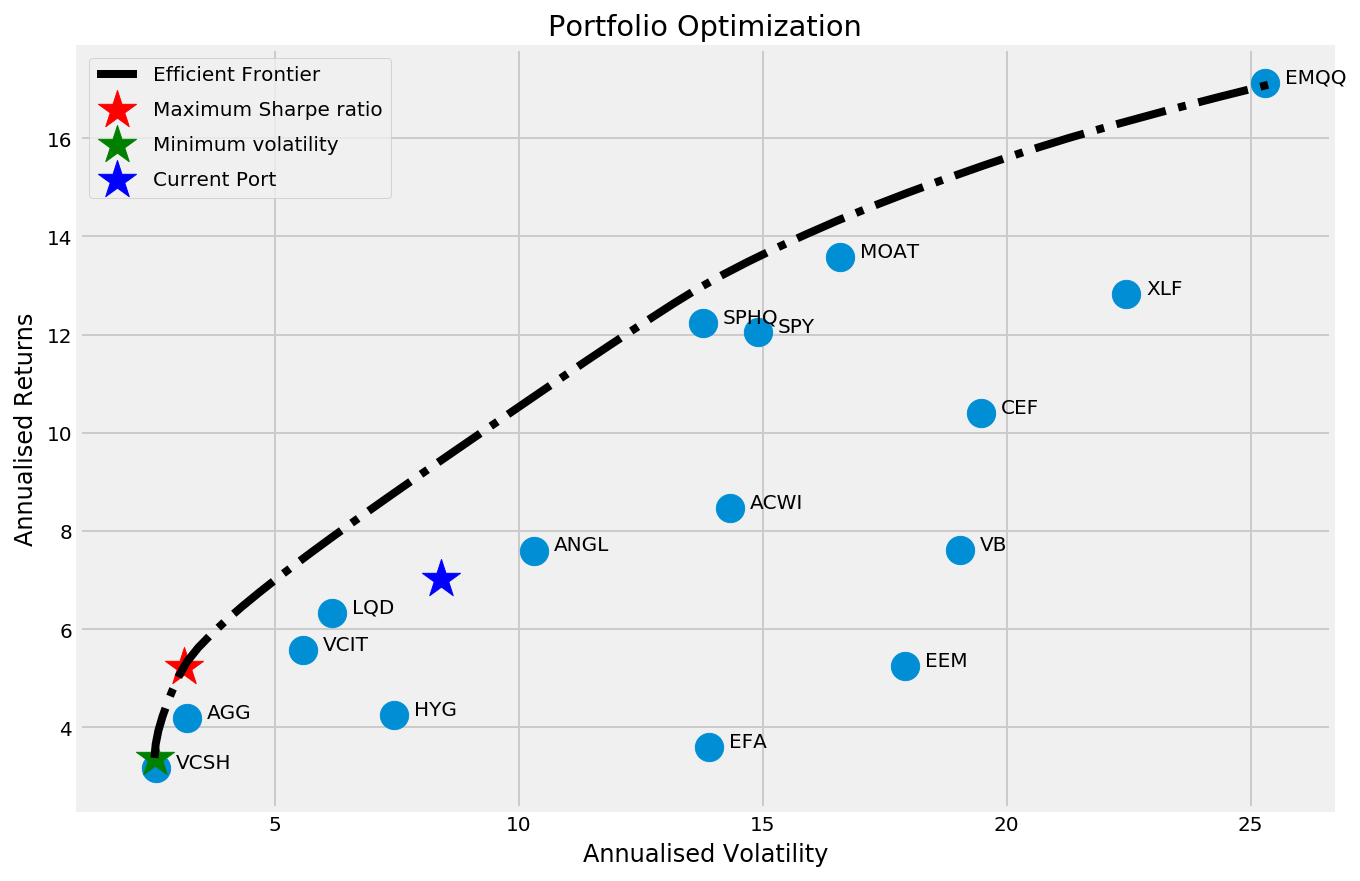

In [21]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

In [16]:
sdp_curr, rp_curr = portfolio_annualised_performance(curr_weights, mean_returns, cov_matrix*100)
rp_curr

7.030523853080294

In [17]:
current_allocation = pd.DataFrame(curr_weights*100,index=datos.columns,columns=['allocation'])
current_allocation.allocation = [round(i,2)for i in current_allocation.allocation]
current_allocation = current_allocation.T
current_allocation

Symbols,VCSH,HYG,LQD,AGG,VCIT,ANGL,ACWI,MOAT,EFA,SPY,SPHQ,EEM,XLF,EMQQ,VB,CEF
allocation,26.6,5.73,5.62,4.31,4.13,4.11,10.41,9.78,7.0,6.09,4.53,3.79,1.56,1.23,1.03,4.08
